In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session


In [ ]:
repository_path = '/kaggle/input/inf8245e-fall-2022/'
train_file_name = 'train.csv'
test_file_name = 'test.csv'
sample_submission_file_name = 'sample_submission.csv'

train_path = repository_path + train_file_name
test_path = repository_path + test_file_name
sample_submission_path = repository_path + sample_submission_file_name

In [ ]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 21 kB/s 


# 1- Load and prepare dataset

when using Kaggle:

In [ ]:
raw_data = pd.read_csv(train_path)
data = raw_data.copy()

raw_test_data = pd.read_csv(test_path)
test_data = raw_test_data.copy()

sample_submission = pd.read_csv(sample_submission_path)

## 1.1- Data exploration

In [ ]:
data

,Id,Band Name,Band Genre,Band Country of Origin,Band Debut,Concert ID,Concert Attendance,Inside Venue,Rain,Seated,Personnality Trait 1,Personnality Trait 2,Personnality Trait 3,Personnality Trait 4,Concert Goer Age,Concert Goer ID,Height (cm),Concert Goer Country of Origin,Concert Enjoyment
0,ConcertExperience_180106,Teenage Crazy Blue Knickers,Indie/Alt Rock,United States of America (USA),1976.0,900.0,2980.0,False,False,NaN,0.330843,-0.958408,-0.943548,-1.636806,29.0,concert_goer_1985,140.0,Paraguay,Did Not Enjoy
1,ConcertExperience_146268,Beyond Devon,Pop Music,United States of America (USA),1968.0,731.0,54.0,True,False,True,-2.069449,0.017777,-1.910675,0.610265,43.0,concert_goer_1874,158.0,United Kingdom (UK),Enjoyed
2,ConcertExperience_128743,Ron Talent,Rock n Roll,Canada,1955.0,NaN,162754.0,False,False,True,-0.484268,1.968772,-0.064167,-1.260871,68.0,concert_goer_442,159.0,United States of America (USA),Did Not Enjoy
3,ConcertExperience_140839,Devon Revival,RnB,United States of America (USA),1992.0,704.0,8103.0,False,True,False,-0.858054,1.022827,-0.348389,-1.147251,17.0,concert_goer_1149,150.0,Canada,Worst Concert Ever
4,ConcertExperience_19149,Beyond Devon,Pop Music,United States of America (USA),1968.0,95.0,54.0,False,False,False,-0.793029,-1.166528,-0.043766,0.969661,59.0,concert_goer_930,166.0,United Kingdom (UK),Did Not Enjoy
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
169995,ConcertExperience_14055,Crazy Joystick Cult,RnB,Canada,1985.0,70.0,162754.0,True,False,False,-0.095021,0.175175,0.914245,0.357359,50.0,concert_goer_707,180.0,United States of America (USA),Did Not Enjoy
169996,ConcertExperience_192792,Crazy Joystick Cult,RnB,Canada,1985.0,963.0,54.0,False,False,False,-0.733719,-0.285776,-0.323312,0.641180,71.0,concert_goer_1373,143.0,Bulgaria,Worst Concert Ever
169997,ConcertExperience_152942,"Why Frogs, Why?",Heavy Metal,Canada,2005.0,764.0,54.0,False,False,False,0.744969,-0.965547,1.020598,1.027389,27.0,concert_goer_1286,176.0,Canada,Did Not Enjoy
169998,ConcertExperience_138957,Twilight of the Joystick Gods,Hip Hop/Rap,United States of America (USA),1995.0,694.0,22026.0,False,True,True,0.821976,0.351411,0.175762,1.455654,39.0,concert_goer_1845,176.0,Canada,Did Not Enjoy


In [ ]:
data.info() # to check the datatype and if there are null-values. 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170000 entries, 0 to 169999
Data columns (total 19 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   Id                              170000 non-null  object 
 1   Band Name                       169141 non-null  object 
 2   Band Genre                      169116 non-null  object 
 3   Band Country of Origin          169210 non-null  object 
 4   Band Debut                      169143 non-null  float64
 5   Concert ID                      169130 non-null  float64
 6   Concert Attendance              169105 non-null  float64
 7   Inside Venue                    169162 non-null  object 
 8   Rain                            169139 non-null  object 
 9   Seated                          169168 non-null  object 
 10  Personnality Trait 1            169148 non-null  float64
 11  Personnality Trait 2            169151 non-null  float64
 12  Personnality Tra

In [ ]:
data.describe()  # mathematically evaluate numerical features

,Band Debut,Concert ID,Concert Attendance,Personnality Trait 1,Personnality Trait 2,Personnality Trait 3,Personnality Trait 4,Concert Goer Age,Height (cm)
count,169143.000000,169130.000000,1.691050e+05,169148.000000,169151.000000,169107.000000,169135.000000,169147.000000,169153.000000
mean,1985.895053,499.360587,2.727906e+05,0.030190,-7.776188,-0.017279,0.003432,46.979822,164.660680
std,16.365288,288.640600,1.641506e+07,0.992067,3237.713866,1.004774,1.006310,17.470503,14.365046
min,1955.000000,0.000000,5.400000e+01,-3.124408,-293861.500146,-3.275108,-3.287787,16.000000,140.000000
25%,1976.000000,249.000000,4.030000e+02,-0.638873,-0.689943,-0.711015,-0.698374,32.000000,152.000000
50%,1988.000000,500.000000,2.980000e+03,0.022664,-0.021836,0.010071,0.015264,47.000000,164.000000
75%,1998.000000,749.750000,2.202600e+04,0.698236,0.648032,0.680300,0.700369,63.000000,177.000000
max,2014.000000,999.000000,1.627540e+09,3.628828,325834.016795,3.308810,3.830923,76.000000,190.000000


In [ ]:
print("Number of concert goers :", len(data['Concert Goer ID'].unique()))
print("Number of concert goers' countries of origin :", len(data['Concert Goer Country of Origin'].unique()))
print("Number of concerts (concert ID ):", len(data['Concert ID'].unique()))
print("Number of bands :", len(data['Band Name'].unique()))
print("Number of band genres:", len(data['Band Genre'].unique()))
print("Number of band debut years :", len(data['Band Debut'].unique()))
print("Number of bands' country of origin :", len(data['Band Country of Origin'].unique()))
print("these resuls incluse null values: NaN")

Number of concert goers : 2001
Number of concert goers' countries of origin : 153
Number of concerts (concert ID ): 1001
Number of bands : 55
Number of band genres: 9
Number of band debut years : 35
Number of bands' country of origin : 5
these resuls incluse null values: NaN


## 1.2- Helper functions

In [ ]:
def drop_column (df , columns_list) : 
    #Inputs:
    # df: the dataframe to be modified.
    #columns_list: a list containing the names of the columns to be deleted 
    return df.drop(columns_list, axis=1)

## 1.3- Data Cleaning

### Concert Goer

First, let's fill the missing data associated with the **concert goers** by mapping Concert Goer ID and filling the other associated features with the mode when the value is Null.

In [ ]:
def concert_goer_cleaning ( data , concert_goer_columns):
    """ Cleans the data associated with the concert goer

      Args:         
          data (pd.DataFrame): The features to clean
          concert_goer_columns (list of string): The columns to modify

      Returns:
          data (pd.DataFrame) : The cleaned dataframe 
      """

    #concert_goer_columns = ['Concert Goer ID', 'Concert Goer Age', 'Concert Goer Country of Origin', 'Personnality Trait 1', 'Personnality Trait 2', 'Personnality Trait 3', 'Personnality Trait 4', 'Height (cm)']
    # lets first remove the rows with missing values in Concert Goer ID
    concert_goer_with_id = data[data['Concert Goer ID'].notnull()]
    # now we can find the rows with missing values in any of the concert_goer_columns
    concert_goer_no_values = concert_goer_with_id[concert_goer_with_id[concert_goer_columns].isnull().any(axis=1)]

    # now let's group the data by Concert Goer ID
    concert_goer_grouped = concert_goer_with_id.groupby('Concert Goer ID', group_keys=False)
    # since for a same Concert Goer ID we should have the same values for the concert_goer_columns we can take the first non null value for each column to replace the missing values
    # so let's replace the missing values of each column with the first non null value of that column on the group
    for column in concert_goer_columns[1:]:
        concert_goer_with_id = concert_goer_with_id.assign(**{column: concert_goer_grouped[column].transform(lambda x: x.fillna(x[x.first_valid_index()]))})

    # we can fill the missing values in the original data
    # we can first drop the rows in data that are present in concert_goer_with_id on the Id column ('Id' is a column in both data and concert_goer_with_id that is unique for each row)
    data = data[~data['Id'].isin(concert_goer_with_id['Id'])]
    # now we can concatenate (because append is deprecated) the rows in concert_goer_with_id to data
    data = pd.concat([data, concert_goer_with_id], ignore_index=False)
    
    # now we need to add the missing values in the rows that have a missing value in the Concert Goer ID column
    # let's first get the rows with missing values in the Concert Goer ID column
    concert_goer_no_id = data[data['Concert Goer ID'].isnull()]
    # let's now drop the rows that don't have a missing values in the other cols
    concert_goer_no_id_no_values = concert_goer_no_id[concert_goer_no_id[concert_goer_columns[1:]].isnull().any(axis=1)]

    # let's get the most similar row in concert_goer_with_id for each row in concert_goer_no_id_no_values and fill the missing values in concert_goer_no_id_no_values with the values of the most similar row in concert_goer_with_id
    import scipy.spatial.distance as distance
    numerical_columns = ['Concert Goer Age', 'Height (cm)', 'Personnality Trait 1', 'Personnality Trait 2', 'Personnality Trait 3', 'Personnality Trait 4']
    for index, row in concert_goer_no_id_no_values.iterrows():
        distance_matrix = distance.cdist(pd.DataFrame([row[numerical_columns]]), concert_goer_with_id[numerical_columns], 'euclidean')
        most_similar_row = concert_goer_with_id.iloc[distance_matrix.argmin()]

        # now lets fill the missing values 
        concert_goer_no_id_no_values.loc[index] = concert_goer_no_id_no_values.loc[index].fillna(most_similar_row)

    # now lets fill data with the rows in concert_goer_no_id_no_values
    data = data[~data['Id'].isin(concert_goer_no_id_no_values['Id'])]
    data = pd.concat([data, concert_goer_no_id_no_values], ignore_index=False)
    
    # reorder the data 
    data = data.sort_index()
    return data


In [ ]:
#Here we keep only the number in the "Concert Goer ID": the original one had "concert_goer_number" we will keep
#Only the number
data["Concert Goer ID"] = data["Concert Goer ID"].str.split("_").str[2]
data["Concert Goer ID"]

0         1985
1         1874
2          442
3         1149
4          930
          ... 
169995     707
169996    1373
169997    1286
169998    1845
169999    1281
Name: Concert Goer ID, Length: 170000, dtype: object

In [ ]:
#Here we keep only the number in the "Concert Goer ID": the original one had "concert_goer_number" we will keep
#Only the number
test_data["Concert Goer ID"] = test_data["Concert Goer ID"].str.split("_").str[2]
test_data["Concert Goer ID"]

0        1587
1         293
2        1068
3        1315
4        1777
         ... 
29995    1710
29996    1758
29997    1481
29998    1461
29999    1617
Name: Concert Goer ID, Length: 30000, dtype: object

In [ ]:
# Let's correct the concert goer missing data in the training data
data = concert_goer_cleaning (data , ['Concert Goer ID', 'Concert Goer Age', 'Concert Goer Country of Origin', 'Personnality Trait 1', 'Personnality Trait 2', 'Personnality Trait 3', 'Personnality Trait 4', 'Height (cm)'])
# Let's do the same with the testing data
test_data = concert_goer_cleaning (test_data , ['Concert Goer ID', 'Concert Goer Age', 'Concert Goer Country of Origin', 'Personnality Trait 1', 'Personnality Trait 2', 'Personnality Trait 3', 'Personnality Trait 4', 'Height (cm)'])

/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1797: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, v, pi)


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 170000 entries, 0 to 169999
Data columns (total 19 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   Id                              170000 non-null  object 
 1   Band Name                       169141 non-null  object 
 2   Band Genre                      169117 non-null  object 
 3   Band Country of Origin          169210 non-null  object 
 4   Band Debut                      169143 non-null  float64
 5   Concert ID                      169130 non-null  float64
 6   Concert Attendance              169105 non-null  float64
 7   Inside Venue                    169163 non-null  object 
 8   Rain                            169139 non-null  object 
 9   Seated                          169168 non-null  object 
 10  Personnality Trait 1            170000 non-null  float64
 11  Personnality Trait 2            170000 non-null  float64
 12  Personnality Tra

In [ ]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30000 entries, 0 to 29999
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Id                              30000 non-null  object 
 1   Band Name                       29864 non-null  object 
 2   Band Genre                      29862 non-null  object 
 3   Band Country of Origin          29844 non-null  object 
 4   Band Debut                      29843 non-null  float64
 5   Concert ID                      29842 non-null  float64
 6   Concert Attendance              29848 non-null  float64
 7   Inside Venue                    29834 non-null  object 
 8   Rain                            29857 non-null  object 
 9   Seated                          29858 non-null  object 
 10  Personnality Trait 1            30000 non-null  float64
 11  Personnality Trait 2            30000 non-null  float64
 12  Personnality Trait 3            

Remove the label column from the training features, and remove useless columns from both sets

In [ ]:
features = drop_column(data ,['Id', 'Concert Enjoyment']) 

In [ ]:
test_ids = test_data["Id"]
test_features = drop_column(test_data , ["Id"])

### Band Name

Then, let's fill the missing data associated with the **bands** by mapping Band Name and filling the other associated features with the mode when the value is Null.

In [ ]:
len(features["Band Name"].unique())

55

In [ ]:
#Verifying the number of nans
print( "Band Genre ",len(features.loc[features["Band Genre"].isna()]))
print( "Band Country of Origin ",len(features.loc[features["Band Country of Origin"].isna()]))
print( "Band Debut ",len(features.loc[features["Band Debut"].isna()]))

Band Genre  883
Band Country of Origin  790
Band Debut  857


In [ ]:
#After examining the unique values of each band column, We can notice that some values have "Insert band name"
#which can be considered as a missing value.
#So let's change these values to np.nan to facilitate their cleaning

#Let's correct "Insert Band Genre":
features.loc[features["Band Genre"] == "Insert Band Genre" , "Band Genre"] = np.nan
test_features.loc[test_features["Band Genre"] == "Insert Band Genre" , "Band Genre"] = np.nan

#Let's correct "Insert Band Debut":
features.loc[features["Band Debut"] == "Insert Band Debut" , "Band Debut"] = np.nan
test_features.loc[test_features["Band Debut"] == "Insert Band Debut" , "Band Debut"] = np.nan

#Let's correct "Insert Band Country of origin":
features.loc[features["Band Country of Origin"] == "Insert Band Country of Origin" , "Band Country of Origin"] = np.nan
test_features.loc[test_features["Band Country of Origin"] == "Insert Band Country of Origin" , "Band Country of Origin"] = np.nan

#Let's correct "Insert Band Name":
features.loc[features["Band Name"] == "Insert Band Name" , "Band Name"] = np.nan
test_features.loc[test_features["Band Name"] == "Insert Band Name" , "Band Name"] = np.nan

In [ ]:
#Verifying the number of nans
#Let's now check the actual number of nans:
print( "Band Genre ",len(features.loc[features["Band Genre"].isna()]))
print( "Band Genre in test data ",len(test_features.loc[test_features["Band Genre"].isna()]))
print("\n")
print( "Band Country of Origin ",len(features.loc[features["Band Country of Origin"].isna()]))
print( "Band Country of Origin in testing data",len(test_features.loc[test_features["Band Country of Origin"].isna()]))
print("\n")
print( "Band Debut ",len(features.loc[features["Band Debut"].isna()]))
print( "Band Debut in testing data",len(test_features.loc[test_features["Band Debut"].isna()]))

Band Genre  964
Band Genre in test data  157


Band Country of Origin  970
Band Country of Origin in testing data 182


Band Debut  857
Band Debut in testing data 157


In [ ]:
band_features = features[["Band Name" , "Band Genre" , "Band Country of Origin" , "Band Debut" , "Concert ID"]]
test_band_features = test_features[["Band Name" , "Band Genre" , "Band Country of Origin" , "Band Debut" , "Concert ID"]]

In [ ]:
#Contains complete information about the bands
df1 = band_features.loc[(~band_features.isna().any(axis=1))].drop_duplicates()
test_df1 = test_band_features.loc[(~test_band_features.isna().any(axis=1))].drop_duplicates()

In [ ]:
df1.head() 

,Band Name,Band Genre,Band Country of Origin,Band Debut,Concert ID
0,Teenage Crazy Blue Knickers,Indie/Alt Rock,United States of America (USA),1976.0,900.0
1,Beyond Devon,Pop Music,United States of America (USA),1968.0,731.0
3,Devon Revival,RnB,United States of America (USA),1992.0,704.0
4,Beyond Devon,Pop Music,United States of America (USA),1968.0,95.0
5,A Dozen Running Iced Frogs,Pop Music,Canada,1998.0,627.0


In [ ]:
test_df1.head()

,Band Name,Band Genre,Band Country of Origin,Band Debut,Concert ID
0,The Crazy Heroes of Devon,Rock n Roll,United States of America (USA),1980.0,350.0
1,Joystick for the Jockies,Hip Hop/Rap,United States of America (USA),2014.0,173.0
2,Puddle of Joystick,Rock n Roll,Canada,2010.0,502.0
4,Devon Revival,RnB,United States of America (USA),1992.0,636.0
5,Crazyplay,Pop Music,United States of America (USA),1995.0,790.0


In [ ]:
df2 = df1[["Band Name" , "Band Genre"]].drop_duplicates()
test_df2 =  test_df1[["Band Name" , "Band Genre"]].drop_duplicates()
df2.loc[df2["Band Name"] == "Twilight of the Joystick Gods"]["Band Genre"].to_list()[0]

'Hip Hop/Rap'

In [ ]:
len(features["Band Name"].unique()) , len(df1["Band Name"].unique())
for name in df2["Band Name"].unique():
    genre = df2.loc[df2["Band Name"] == name]["Band Genre"].to_list()[0]
    features.loc[(features["Band Name"] == name ) & (features["Band Genre"].isna()), "Band Genre"] = genre

In [ ]:
for name in test_df2["Band Name"].unique():
    genre = test_df2.loc[test_df2["Band Name"] == name]["Band Genre"].to_list()[0]
    test_features.loc[(test_features["Band Name"] == name ) & (test_features["Band Genre"].isna()), "Band Genre"] = genre

In [ ]:
len(features.loc[features["Band Debut"].isna()]) , len(test_features.loc[test_features["Band Debut"].isna()])

(857, 157)

In [ ]:
df3 = df1[["Band Name" , "Band Debut"]].drop_duplicates()
for name in df2["Band Name"].unique():
    dod = df3.loc[df3["Band Name"] == name]["Band Debut"].to_list()[0]
    features.loc[(features["Band Name"] == name ) & (features["Band Debut"].isna()), "Band Debut"] = dod

In [ ]:
test_df3 = test_df1[["Band Name" , "Band Debut"]].drop_duplicates()
for name in test_df2["Band Name"].unique():
    dod = test_df3.loc[test_df3["Band Name"] == name]["Band Debut"].to_list()[0]
    test_features.loc[(test_features["Band Name"] == name ) & (test_features["Band Debut"].isna()), "Band Debut"] = dod

In [ ]:
features.loc[features["Band Debut"].isna()]

,Band Name,Band Genre,Band Country of Origin,Band Debut,Concert ID,Concert Attendance,Inside Venue,Rain,Seated,Personnality Trait 1,Personnality Trait 2,Personnality Trait 3,Personnality Trait 4,Concert Goer Age,Concert Goer ID,Height (cm),Concert Goer Country of Origin
5180,NaN,Heavy Metal,United States of America (USA),NaN,767.0,2980.0,False,False,True,0.174657,-0.738140,0.727398,-0.668455,71.0,1885,150.0,Canada
146893,NaN,Hip Hop/Rap,Canada,NaN,125.0,1096.0,False,False,False,0.423639,1.288772,1.441726,-1.544930,33.0,561,179.0,United Kingdom (UK)


In [ ]:
test_features.loc[test_features["Band Debut"].isna()]

,Band Name,Band Genre,Band Country of Origin,Band Debut,Concert ID,Concert Attendance,Inside Venue,Rain,Seated,Personnality Trait 1,Personnality Trait 2,Personnality Trait 3,Personnality Trait 4,Concert Goer Age,Concert Goer ID,Height (cm),Concert Goer Country of Origin
17478,NaN,RnB,United States of America (USA),NaN,309.0,8103.0,False,True,True,0.628007,2.279765,-1.832654,0.541213,52.0,511,173.0,Canada


In [ ]:
features.loc[(features["Concert ID"] == 767) & (features.isna().any(axis=1)) , ["Band Name" , "Band Debut"]] = ["Disciples Of Devon" , 1988.0]

In [ ]:
t = test_features.loc[test_features["Concert ID"] == 309][['Band Name' , "Band Debut"]].iloc[0]
test_features.loc[(test_features["Concert ID"] == 309) & (test_features.isna().any(axis=1)) , ["Band Name" , "Band Debut"]] = [t["Band Name"] , t["Band Debut"]]

In [ ]:
df4 = df1[["Band Name" , "Band Country of Origin"]].drop_duplicates()
for name in df4["Band Name"].unique():
    coo = df4.loc[df4["Band Name"] == name]["Band Country of Origin"].to_list()[0]
    features.loc[(features["Band Name"] == name ) & (features["Band Country of Origin"].isna()), "Band Country of Origin"] = coo

In [ ]:
test_df4 = test_df1[["Band Name" , "Band Country of Origin"]].drop_duplicates()
for name in test_df4["Band Name"].unique():
    coo = test_df4.loc[test_df4["Band Name"] == name]["Band Country of Origin"].to_list()[0]
    test_features.loc[(test_features["Band Name"] == name ) & (test_features["Band Country of Origin"].isna()), "Band Country of Origin"] = coo

In [ ]:
CID = features.loc[features["Band Country of Origin"].isna()]["Concert ID"].values[0]
features.loc[(features["Concert ID"] == CID)& (features["Band Country of Origin"].isna()) ,"Band Country of Origin" ] = "United States of America (USA)" 

In [ ]:
test_CID = test_features.loc[test_features["Band Country of Origin"].isna()]["Concert ID"].values[0]
test_features.loc[(test_features["Concert ID"] == CID)& (test_features["Band Country of Origin"].isna()) ,"Band Country of Origin" ] = "United States of America (USA)" 

In [ ]:
features["Band Name"].unique() , features["Band Country of Origin"].unique()

(array(['Teenage Crazy Blue Knickers', 'Beyond Devon', 'Ron Talent',
        'Devon Revival', 'A Dozen Running Iced Frogs', 'Big Joystick',
        "Ron's Midnight Jockies", 'Running in Devon', 'Running Twins',
        'Ronatron', 'Big Division', 'The Crazy Heroes of Devon',
        'My Heart, Your Thighs', nan, 'Joystick Army', 'This Joystick',
        'Disciples Of Devon', 'Purely Blue', 'Crazy Crazy', 'King Blue',
        'Why Frogs, Why?', 'Twilight of the Joystick Gods',
        'Crazy Joystick Cult', 'Joystick of the Big Knickers',
        'Joystick for the Jockies', 'Joystick A Dozen', 'Frogsica',
        'Rubbish Devon Frogs', 'Running for the Crazy Woman',
        'Knickers for the Jockies', 'Knickers A Dozen',
        'The Running Crazy Jockies', 'Running at the Disco', 'Big Autumn',
        'Crazy Dream and a Pinch of Joystick', 'Puddle of Joystick',
        "It's My Joystick", 'Joystick Attack', 'Crazyplay',
        'Devon Thunder Thighs', 'The Running Knickers',
        'T

In [ ]:
for ids in df1["Concert ID"].unique():
    Name = df1.loc[df1["Concert ID"] == ids]["Band Name"].to_list()[0]
    features.loc[(features["Concert ID"] == ids ) &(features["Band Name"].isna()) , "Band Name"] = Name

In [ ]:
for ids in test_df1["Concert ID"].unique():
    test_Name = test_df1.loc[test_df1["Concert ID"] == ids]["Band Name"].to_list()[0]
    test_features.loc[(test_features["Concert ID"] == ids ) &(test_features["Band Name"].isna()) , "Band Name"] = test_Name

In [ ]:
print( "Band Name ",len(features.loc[features["Band Name"].isna()]))
print( "Band Name ",len(features.loc[features["Band Name"] == "Insert Band Name"]))

print( "test Band Name ",len(test_features.loc[test_features["Band Name"].isna()]))

Band Name  6
Band Name  0
test Band Name  0


In [ ]:
features.loc[features["Concert ID"] == 844.0  , "Band Name"] = "Running at the Disco"

In [ ]:
#Verifying the number of nans
print("training features report:")
print( "Band Genre ",len(features.loc[features["Band Genre"].isna()]))
print( "Band Country of Origin ",len(features.loc[features["Band Country of Origin"].isna()]))
print( "Band Debut ",len(features.loc[features["Band Debut"].isna()]))
print( "Band Name ",len(features.loc[features["Band Name"].isna()]))
print("\n")
print("test features report:")
print( "Band Genre ",len(test_features.loc[test_features["Band Genre"].isna()]))
print( "Band Country of Origin ",len(test_features.loc[test_features["Band Country of Origin"].isna()]))
print( "Band Debut ",len(test_features.loc[test_features["Band Debut"].isna()]))
print( "Band Name ",len(test_features.loc[test_features["Band Name"].isna()]))

training features report:
Band Genre  8
Band Country of Origin  2
Band Debut  1
Band Name  6


test features report:
Band Genre  2
Band Country of Origin  2
Band Debut  0
Band Name  0


In [ ]:
#A new version of this dataframe
df1 = band_features.loc[(~band_features.isna().any(axis=1))].drop_duplicates()
df1.head()

,Band Name,Band Genre,Band Country of Origin,Band Debut,Concert ID
0,Teenage Crazy Blue Knickers,Indie/Alt Rock,United States of America (USA),1976.0,900.0
1,Beyond Devon,Pop Music,United States of America (USA),1968.0,731.0
3,Devon Revival,RnB,United States of America (USA),1992.0,704.0
4,Beyond Devon,Pop Music,United States of America (USA),1968.0,95.0
5,A Dozen Running Iced Frogs,Pop Music,Canada,1998.0,627.0


In [ ]:
#A new version of this dataframe for testing data
test_df1 = test_band_features.loc[(~test_band_features.isna().any(axis=1))].drop_duplicates()
test_df1.head()

,Band Name,Band Genre,Band Country of Origin,Band Debut,Concert ID
0,The Crazy Heroes of Devon,Rock n Roll,United States of America (USA),1980.0,350.0
1,Joystick for the Jockies,Hip Hop/Rap,United States of America (USA),2014.0,173.0
2,Puddle of Joystick,Rock n Roll,Canada,2010.0,502.0
4,Devon Revival,RnB,United States of America (USA),1992.0,636.0
5,Crazyplay,Pop Music,United States of America (USA),1995.0,790.0


In [ ]:
#For the training 
for ids in df1["Concert ID"].unique():
    Name = df1.loc[df1["Concert ID"] == ids]["Band Name"].to_list()[0]
    dod = df1.loc[df1["Concert ID"] == ids]["Band Debut"].to_list()[0]
    coo = df1.loc[df1["Concert ID"] == ids]["Band Country of Origin"].to_list()[0]
    genre = df1.loc[df1["Concert ID"] == ids]["Band Genre"].to_list()[0]
    features.loc[(features["Concert ID"] == ids ) &(band_features.isna().any(axis=1)) , ["Band Name" , "Band Debut" , "Band Country of Origin" , "Band Genre"]] = [Name , dod , coo , genre]

In [ ]:
#For the testing data now
for ids in test_df1["Concert ID"].unique():
    Name = test_df1.loc[test_df1["Concert ID"] == ids]["Band Name"].to_list()[0]
    dod = test_df1.loc[test_df1["Concert ID"] == ids]["Band Debut"].to_list()[0]
    coo = test_df1.loc[test_df1["Concert ID"] == ids]["Band Country of Origin"].to_list()[0]
    genre = test_df1.loc[test_df1["Concert ID"] == ids]["Band Genre"].to_list()[0]
    test_features.loc[(test_features["Concert ID"] == ids ) &(test_band_features.isna().any(axis=1)) , ["Band Name" , "Band Debut" , "Band Country of Origin" , "Band Genre"]] = [Name , dod , coo , genre]

In [ ]:
#Verifying the number of nans
print("for the training data")
print( "Band Genre ",len(features.loc[features["Band Genre"].isna()]))
print( "Band Country of Origin ",len(features.loc[features["Band Country of Origin"].isna()]))
print( "Band Debut ",len(features.loc[features["Band Debut"].isna()]))
print( "Band Name ",len(features.loc[features["Band Name"].isna()]))
print("\n")
print("For the testing data")
print( "Band Genre ",len(test_features.loc[test_features["Band Genre"].isna()]))
print( "Band Country of Origin ",len(test_features.loc[test_features["Band Country of Origin"].isna()]))
print( "Band Debut ",len(test_features.loc[test_features["Band Debut"].isna()]))
print( "Band Name ",len(test_features.loc[test_features["Band Name"].isna()]))

for the training data
Band Genre  0
Band Country of Origin  0
Band Debut  0
Band Name  6


For the testing data
Band Genre  0
Band Country of Origin  0
Band Debut  0
Band Name  0


In [ ]:
temp_df = features.loc[features["Band Name"].isna()]
temp_df.index

Int64Index([35230, 61944, 79278, 103897, 109545, 120413], dtype='int64')

In [ ]:
# we still have 6 missing Band Names
#those missing values are due to the Concert ID being NAN
#First let's find the 6 missing values in a dataframe
temp_df = features.loc[features["Band Name"].isna()]

#Now we will try and find the band and concert ID at once by comparing the other band features like 
#Band Genere , Band Country of Origin and Band Debut as well as the Concert Attendence
for idx  in temp_df.index:
    #Let's find the concert id and the band names
    bg , bcoo , bdod , ca = features.iloc[idx][["Band Genre" , "Band Country of Origin" , "Band Debut" , "Concert Attendance"]]
    [bn , concertid ]= features.loc[(features["Band Genre"] == bg) &( features["Band Country of Origin"] == bcoo) & (features["Band Debut"] == bdod) & (features ["Concert Attendance"]== ca)].iloc[0][["Band Name","Concert ID"]]
    #Let's now inject them in the features dataframe
    features.loc[idx , ['Band Name' , "Concert ID"]] = [bn , concertid ]
    

In [ ]:
features['Band Debut'].unique()

array([1976., 1968., 1955., 1992., 1998., 1969., 1980., 2006., 2000.,
       1958., 1978., 2005., 1971., 1988., 1977., 1974., 1995., 1985.,
       1979., 2014., 1991., 2004., 1964., 1990., 1996., 1993., 2010.,
       1983., 2008., 1984., 1963., 2011., 2003., 1959.])

In [ ]:
len(features["Concert ID"].unique())

1001

In [ ]:
features

,Band Name,Band Genre,Band Country of Origin,Band Debut,Concert ID,Concert Attendance,Inside Venue,Rain,Seated,Personnality Trait 1,Personnality Trait 2,Personnality Trait 3,Personnality Trait 4,Concert Goer Age,Concert Goer ID,Height (cm),Concert Goer Country of Origin
0,Teenage Crazy Blue Knickers,Indie/Alt Rock,United States of America (USA),1976.0,900.0,2980.0,False,False,NaN,0.330843,-0.958408,-0.943548,-1.636806,29.0,1985,140.0,Paraguay
1,Beyond Devon,Pop Music,United States of America (USA),1968.0,731.0,54.0,True,False,True,-2.069449,0.017777,-1.910675,0.610265,43.0,1874,158.0,United Kingdom (UK)
2,Ron Talent,Rock n Roll,Canada,1955.0,NaN,162754.0,False,False,True,-0.484268,1.968772,-0.064167,-1.260871,68.0,442,159.0,United States of America (USA)
3,Devon Revival,RnB,United States of America (USA),1992.0,704.0,8103.0,False,True,False,-0.858054,1.022827,-0.348389,-1.147251,17.0,1149,150.0,Canada
4,Beyond Devon,Pop Music,United States of America (USA),1968.0,95.0,54.0,False,False,False,-0.793029,-1.166528,-0.043766,0.969661,59.0,930,166.0,United Kingdom (UK)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
169995,Crazy Joystick Cult,RnB,Canada,1985.0,70.0,162754.0,True,False,False,-0.095021,0.175175,0.914245,0.357359,50.0,707,180.0,United States of America (USA)
169996,Crazy Joystick Cult,RnB,Canada,1985.0,963.0,54.0,False,False,False,-0.733719,-0.285776,-0.323312,0.641180,71.0,1373,143.0,Bulgaria
169997,"Why Frogs, Why?",Heavy Metal,Canada,2005.0,764.0,54.0,False,False,False,0.744969,-0.965547,1.020598,1.027389,27.0,1286,176.0,Canada
169998,Twilight of the Joystick Gods,Hip Hop/Rap,United States of America (USA),1995.0,694.0,22026.0,False,True,True,0.821976,0.351411,0.175762,1.455654,39.0,1845,176.0,Canada


### Concert ID

Third, let's fill the missing data associated with the concert by mapping Concert ID and filling the other associated features with the mode when the value is Null.

In [ ]:
import math

In [ ]:
# replaces the Nan values and error values (for example, for the same concert, the attendance should be the same, if there is a wrong entry, we replace it with the mode)

def concert_data_correction (features):
    """ Cleans the data associated with the concert 

      Args:         
          features (pd.DataFrame): The features to clean
          
      Returns:
          features (pd.DataFrame) : The cleaned dataframe 
      """
  
    concerts = features['Concert ID'].unique()

    for concert in concerts:
      if math.isnan(concert):
        #print(concert, math.isnan(concert)) # deal with this too
        pass
      else:   

        concert_df = features.loc[features["Concert ID"] == concert]
        # compute the mode of each column for that specific concert:
        mode_df = concert_df.mode(axis="rows")
        mode_concertID = mode_df.loc[0,"Concert Attendance"]
        mode_inside = mode_df.loc[0,"Inside Venue"]
        mode_rain = mode_df.loc[0,"Rain"]

        # Fill the concert attendance nan and noisy values:
        features.loc[features["Concert ID"] == concert, ["Concert Attendance"]] = mode_concertID

        # Fill the concert inside venue nan and noisy values:
        features.loc[features["Concert ID"] == concert, ["Inside Venue"]] = mode_inside

        # Fill the concert Rain nan and noisy values:
        features.loc[features["Concert ID"] == concert, ["Rain"]] = mode_rain
    
    return (features)

In [ ]:
#Here  we try to fill the missing concert IDs assuming that if we have the same "Band Name" and the same "Concert Attendance"
#Then it's the same concert.
def concert_ID_correction (features : pd.DataFrame):
    """ corrects the data associated with the concert goer

      Args:         
          data (pd.DataFrame): The features to clean
          concert_goer_columns (list of string): The columns to modify

      Returns:
          data (pd.DataFrame) : The cleaned dataframe 
      """

    for idx in features.loc[features["Concert ID"].isna()].index:
      Bn , cA = features.iloc[idx][["Band Name" , "Concert Attendance"]]
      idnd = features.loc[(features["Band Name"] == Bn) & (features ["Concert Attendance"] == cA) & (~features["Concert ID"].isna())]["Concert ID"].index
      try:
        features.loc[idx , "Concert ID"] = features.iloc[idnd[0]] ["Concert ID"]
      except:
        features.loc[idx , "Concert ID"] = features['Concert ID'].mean()
    return features

In [ ]:
features = concert_data_correction(features)
test_features = concert_data_correction(test_features)

In [ ]:
features = concert_ID_correction (features)
test_features = concert_ID_correction(test_features)

In [ ]:
print("test concert id nans :" , len(test_features.loc[test_features["Concert ID"].isna()]))
print("train concert id nans:" , len(features.loc[features["Concert ID"].isna()]))

test concert id nans : 0
train concert id nans: 0


In [ ]:
test_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30000 entries, 0 to 29999
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Band Name                       30000 non-null  object 
 1   Band Genre                      30000 non-null  object 
 2   Band Country of Origin          30000 non-null  object 
 3   Band Debut                      30000 non-null  float64
 4   Concert ID                      30000 non-null  float64
 5   Concert Attendance              30000 non-null  float64
 6   Inside Venue                    30000 non-null  object 
 7   Rain                            30000 non-null  object 
 8   Seated                          29858 non-null  object 
 9   Personnality Trait 1            30000 non-null  float64
 10  Personnality Trait 2            30000 non-null  float64
 11  Personnality Trait 3            30000 non-null  float64
 12  Personnality Trait 4            

In [ ]:
features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 170000 entries, 0 to 169999
Data columns (total 17 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   Band Name                       170000 non-null  object 
 1   Band Genre                      170000 non-null  object 
 2   Band Country of Origin          170000 non-null  object 
 3   Band Debut                      170000 non-null  float64
 4   Concert ID                      170000 non-null  float64
 5   Concert Attendance              169995 non-null  float64
 6   Inside Venue                    169991 non-null  object 
 7   Rain                            169997 non-null  object 
 8   Seated                          169168 non-null  object 
 9   Personnality Trait 1            170000 non-null  float64
 10  Personnality Trait 2            170000 non-null  float64
 11  Personnality Trait 3            170000 non-null  float64
 12  Personnality Tra

In [ ]:
# there are still a few  NaN values, replace them with the mean

features.loc[:, "Concert Attendance"] = features.loc[:, "Concert Attendance"].fillna(features["Concert Attendance"].mean())
features.loc[:, "Inside Venue"] = features.loc[:, "Inside Venue"].fillna(features["Inside Venue"].mean())
features.loc[:, "Rain"] = features.loc[:, "Rain"].fillna(features["Rain"].mean())


In [ ]:
#check:
features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 170000 entries, 0 to 169999
Data columns (total 17 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   Band Name                       170000 non-null  object 
 1   Band Genre                      170000 non-null  object 
 2   Band Country of Origin          170000 non-null  object 
 3   Band Debut                      170000 non-null  float64
 4   Concert ID                      170000 non-null  float64
 5   Concert Attendance              170000 non-null  float64
 6   Inside Venue                    170000 non-null  object 
 7   Rain                            170000 non-null  object 
 8   Seated                          169168 non-null  object 
 9   Personnality Trait 1            170000 non-null  float64
 10  Personnality Trait 2            170000 non-null  float64
 11  Personnality Trait 3            170000 non-null  float64
 12  Personnality Tra

In [ ]:
test_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30000 entries, 0 to 29999
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Band Name                       30000 non-null  object 
 1   Band Genre                      30000 non-null  object 
 2   Band Country of Origin          30000 non-null  object 
 3   Band Debut                      30000 non-null  float64
 4   Concert ID                      30000 non-null  float64
 5   Concert Attendance              30000 non-null  float64
 6   Inside Venue                    30000 non-null  object 
 7   Rain                            30000 non-null  object 
 8   Seated                          29858 non-null  object 
 9   Personnality Trait 1            30000 non-null  float64
 10  Personnality Trait 2            30000 non-null  float64
 11  Personnality Trait 3            30000 non-null  float64
 12  Personnality Trait 4            

### Seated 

The parameter Seated is not related to the Concert ID or Inside Venue. We will fill it with a random value 

In [ ]:
features

,Band Name,Band Genre,Band Country of Origin,Band Debut,Concert ID,Concert Attendance,Inside Venue,Rain,Seated,Personnality Trait 1,Personnality Trait 2,Personnality Trait 3,Personnality Trait 4,Concert Goer Age,Concert Goer ID,Height (cm),Concert Goer Country of Origin
0,Teenage Crazy Blue Knickers,Indie/Alt Rock,United States of America (USA),1976.0,900.0,2980.0,False,False,NaN,0.330843,-0.958408,-0.943548,-1.636806,29.0,1985,140.0,Paraguay
1,Beyond Devon,Pop Music,United States of America (USA),1968.0,731.0,54.0,True,False,True,-2.069449,0.017777,-1.910675,0.610265,43.0,1874,158.0,United Kingdom (UK)
2,Ron Talent,Rock n Roll,Canada,1955.0,794.0,162754.0,False,False,True,-0.484268,1.968772,-0.064167,-1.260871,68.0,442,159.0,United States of America (USA)
3,Devon Revival,RnB,United States of America (USA),1992.0,704.0,8103.0,False,True,False,-0.858054,1.022827,-0.348389,-1.147251,17.0,1149,150.0,Canada
4,Beyond Devon,Pop Music,United States of America (USA),1968.0,95.0,54.0,False,False,False,-0.793029,-1.166528,-0.043766,0.969661,59.0,930,166.0,United Kingdom (UK)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
169995,Crazy Joystick Cult,RnB,Canada,1985.0,70.0,162754.0,True,False,False,-0.095021,0.175175,0.914245,0.357359,50.0,707,180.0,United States of America (USA)
169996,Crazy Joystick Cult,RnB,Canada,1985.0,963.0,54.0,False,False,False,-0.733719,-0.285776,-0.323312,0.641180,71.0,1373,143.0,Bulgaria
169997,"Why Frogs, Why?",Heavy Metal,Canada,2005.0,764.0,54.0,False,False,False,0.744969,-0.965547,1.020598,1.027389,27.0,1286,176.0,Canada
169998,Twilight of the Joystick Gods,Hip Hop/Rap,United States of America (USA),1995.0,694.0,22026.0,False,True,True,0.821976,0.351411,0.175762,1.455654,39.0,1845,176.0,Canada


In [ ]:
features['Seated'] = features['Seated'].fillna(method = 'bfill')
test_features['Seated'] = test_features['Seated'].fillna(method = 'bfill')

In [ ]:
#check:
features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 170000 entries, 0 to 169999
Data columns (total 17 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   Band Name                       170000 non-null  object 
 1   Band Genre                      170000 non-null  object 
 2   Band Country of Origin          170000 non-null  object 
 3   Band Debut                      170000 non-null  float64
 4   Concert ID                      170000 non-null  float64
 5   Concert Attendance              170000 non-null  float64
 6   Inside Venue                    170000 non-null  object 
 7   Rain                            170000 non-null  object 
 8   Seated                          170000 non-null  bool   
 9   Personnality Trait 1            170000 non-null  float64
 10  Personnality Trait 2            170000 non-null  float64
 11  Personnality Trait 3            170000 non-null  float64
 12  Personnality Tra

In [ ]:
test_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30000 entries, 0 to 29999
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Band Name                       30000 non-null  object 
 1   Band Genre                      30000 non-null  object 
 2   Band Country of Origin          30000 non-null  object 
 3   Band Debut                      30000 non-null  float64
 4   Concert ID                      30000 non-null  float64
 5   Concert Attendance              30000 non-null  float64
 6   Inside Venue                    30000 non-null  object 
 7   Rain                            30000 non-null  object 
 8   Seated                          30000 non-null  bool   
 9   Personnality Trait 1            30000 non-null  float64
 10  Personnality Trait 2            30000 non-null  float64
 11  Personnality Trait 3            30000 non-null  float64
 12  Personnality Trait 4            

### Features and labels


In [ ]:
labels = data['Concert Enjoyment']


## 1.4- Preprocessing

In [ ]:
from sklearn import preprocessing

### Data encoding

We can split the features in 3 types: Categorical features that need to be encoded (one-hot encoder) Numerical features that need to be scaled and normalized and bool features that need to be encoded as 0/1

In [ ]:
features.loc[:, 'Concert ID'].fillna(features['Concert ID'].mean() , inplace = True)
test_features.loc[:, 'Concert ID'].fillna(test_features['Concert ID'].mean() , inplace =True)

In [ ]:
features["Concert Goer ID"] = features["Concert Goer ID"].astype(float)
test_features["Concert Goer ID"] = test_features["Concert Goer ID"].astype(float)

In [ ]:
features.loc[:, 'Concert Goer ID'].fillna(features['Concert Goer ID'].mean() , inplace = True)
test_features.loc[:, 'Concert Goer ID'].fillna(test_features['Concert Goer ID'].mean() , inplace =True)

In [ ]:
features["Concert Goer ID"]

0         1985.0
1         1874.0
2          442.0
3         1149.0
4          930.0
           ...  
169995     707.0
169996    1373.0
169997    1286.0
169998    1845.0
169999    1281.0
Name: Concert Goer ID, Length: 170000, dtype: float64

Let's add a column whose value equals 1 when the concert goer and the band are from the same country and zero otherwise

In [ ]:
features["Same Country"] = features["Band Country of Origin"] == features["Concert Goer Country of Origin"]
test_features["Same Country"] = test_features["Band Country of Origin"] == test_features["Concert Goer Country of Origin"]
features = features.drop(["Band Country of Origin", "Concert Goer Country of Origin"], axis=1)
test_features = test_features.drop(["Band Country of Origin", "Concert Goer Country of Origin"], axis=1)


In [ ]:
# categorical_features = ['Band Name', 'Band Genre', 'Band Country of Origin', 'Concert Goer Country of Origin']
categorical_features = ['Band Name', 'Band Genre']
boolean_features = ['Inside Venue', 'Rain', 'Seated', 'Same Country']
#numerical_features = ['Band Debut', 'Concert Attendance', 'Personnality Trait 1', 'Personnality Trait 2', 'Personnality Trait 3', 'Personnality Trait 4', 'Concert Goer Age', 'Height (cm)']
numerical_features = ['Concert ID','Band Debut', 'Concert Attendance', 'Personnality Trait 1', 'Personnality Trait 2', 'Personnality Trait 3', 'Personnality Trait 4', 'Concert Goer Age', 'Height (cm)' , 'Concert Goer ID']

**Boolean Features: 0/1 encoder**

In [ ]:
# there are only 3 boolean columns: Inside Venue, Rain, Seated
features[boolean_features] = features[boolean_features].astype(int)
test_features[boolean_features] = test_features[boolean_features].astype(int)

In [ ]:
features

,Band Name,Band Genre,Band Debut,Concert ID,Concert Attendance,Inside Venue,Rain,Seated,Personnality Trait 1,Personnality Trait 2,Personnality Trait 3,Personnality Trait 4,Concert Goer Age,Concert Goer ID,Height (cm),Same Country
0,Teenage Crazy Blue Knickers,Indie/Alt Rock,1976.0,900.0,2980.0,0,0,1,0.330843,-0.958408,-0.943548,-1.636806,29.0,1985.0,140.0,0
1,Beyond Devon,Pop Music,1968.0,731.0,54.0,1,0,1,-2.069449,0.017777,-1.910675,0.610265,43.0,1874.0,158.0,0
2,Ron Talent,Rock n Roll,1955.0,794.0,162754.0,0,0,1,-0.484268,1.968772,-0.064167,-1.260871,68.0,442.0,159.0,0
3,Devon Revival,RnB,1992.0,704.0,8103.0,0,1,0,-0.858054,1.022827,-0.348389,-1.147251,17.0,1149.0,150.0,0
4,Beyond Devon,Pop Music,1968.0,95.0,54.0,0,0,0,-0.793029,-1.166528,-0.043766,0.969661,59.0,930.0,166.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
169995,Crazy Joystick Cult,RnB,1985.0,70.0,162754.0,1,0,0,-0.095021,0.175175,0.914245,0.357359,50.0,707.0,180.0,0
169996,Crazy Joystick Cult,RnB,1985.0,963.0,54.0,0,0,0,-0.733719,-0.285776,-0.323312,0.641180,71.0,1373.0,143.0,0
169997,"Why Frogs, Why?",Heavy Metal,2005.0,764.0,54.0,0,0,0,0.744969,-0.965547,1.020598,1.027389,27.0,1286.0,176.0,1
169998,Twilight of the Joystick Gods,Hip Hop/Rap,1995.0,694.0,22026.0,0,1,1,0.821976,0.351411,0.175762,1.455654,39.0,1845.0,176.0,0


In [ ]:
test_features

,Band Name,Band Genre,Band Debut,Concert ID,Concert Attendance,Inside Venue,Rain,Seated,Personnality Trait 1,Personnality Trait 2,Personnality Trait 3,Personnality Trait 4,Concert Goer Age,Concert Goer ID,Height (cm),Same Country
0,The Crazy Heroes of Devon,Rock n Roll,1980.0,350.0,2980.0,1,0,1,1.065107,0.057660,0.249639,-0.933976,74.0,1587.0,165.0,1
1,Joystick for the Jockies,Hip Hop/Rap,2014.0,173.0,8103.0,1,1,0,-0.886947,0.801365,0.525624,0.176655,29.0,293.0,151.0,0
2,Puddle of Joystick,Rock n Roll,2010.0,502.0,2980.0,1,1,0,0.744700,-0.797531,-0.034166,-0.226052,27.0,1068.0,146.0,1
3,Flight of the Knickers,Hip Hop/Rap,2014.0,532.0,22026.0,1,0,0,-0.134180,-0.361512,0.969404,-2.341205,38.0,1315.0,183.0,0
4,Devon Revival,RnB,1992.0,636.0,2980.0,0,0,0,1.407366,-0.084155,-0.673233,1.733714,21.0,1777.0,177.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,Joystick of the Big Knickers,Hip Hop/Rap,1979.0,411.0,2980.0,1,0,0,-0.421714,-1.549670,-0.351770,0.132489,42.0,1710.0,178.0,1
29996,Big Division,Hip Hop/Rap,1978.0,135.0,8103.0,1,0,0,0.615087,-0.047092,0.339228,0.820159,37.0,1758.0,186.0,0
29997,Crazyplay,Pop Music,1995.0,987.0,8103.0,0,0,1,-1.396551,-0.508627,-1.692584,1.640931,45.0,1481.0,158.0,0
29998,Lord of the Crazy Frogs,RnB,1968.0,830.0,8103.0,0,1,0,0.168073,-0.785460,0.898273,1.608389,36.0,1461.0,170.0,0


**Categorical Features: One-hot encoder**

In [ ]:
from sklearn.preprocessing import OneHotEncoder

In [ ]:
categorical_features
print("Train Data: ")
print("Number of Band Names                    :", len(features["Band Name"].unique()))
print("Number of Band Genre                    :", len(features["Band Genre"].unique()))

print("Test Data: ")
print("Number of Band Names                    :", len(test_features["Band Name"].unique()))
print("Number of Band Genre                    :", len(test_features["Band Genre"].unique()))


Train Data: 
Number of Band Names                    : 53
Number of Band Genre                    : 7
Test Data: 
Number of Band Names                    : 53
Number of Band Genre                    : 7


**Band names:**

In [ ]:
# Encode categorical features

ohe = OneHotEncoder(categories='auto')
ohe.fit(features[categorical_features])
feature_arr = ohe.transform(features[categorical_features]).toarray()
feature_labels = ohe.get_feature_names_out()
encoded_categorical_features = pd.DataFrame(feature_arr)
encoded_categorical_features.set_axis(feature_labels,axis=1, inplace=True)


In [ ]:
# Encode test features with the same encoder
test_feature_arr = ohe.transform(test_features[categorical_features]).toarray()
encoded_categorical_test_features = pd.DataFrame(test_feature_arr)
encoded_categorical_test_features.set_axis(feature_labels,axis=1, inplace=True)


In [ ]:
encoded_categorical_features

,Band Name_A Dozen Running Iced Frogs,Band Name_Allo Knickers,Band Name_Beyond Devon,Band Name_Big Autumn,Band Name_Big Division,Band Name_Big Frogs Dream,Band Name_Big Joystick,Band Name_Crazy Crazy,Band Name_Crazy Dream and a Pinch of Joystick,Band Name_Crazy Frogs of Devon,...,Band Name_Twilight of the Joystick Gods,Band Name_Undercover Joystick and the Crazy Knickers,"Band Name_Why Frogs, Why?",Band Genre_Country,Band Genre_Heavy Metal,Band Genre_Hip Hop/Rap,Band Genre_Indie/Alt Rock,Band Genre_Pop Music,Band Genre_RnB,Band Genre_Rock n Roll
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
169995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
169996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
169997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
169998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [ ]:
encoded_categorical_test_features

,Band Name_A Dozen Running Iced Frogs,Band Name_Allo Knickers,Band Name_Beyond Devon,Band Name_Big Autumn,Band Name_Big Division,Band Name_Big Frogs Dream,Band Name_Big Joystick,Band Name_Crazy Crazy,Band Name_Crazy Dream and a Pinch of Joystick,Band Name_Crazy Frogs of Devon,...,Band Name_Twilight of the Joystick Gods,Band Name_Undercover Joystick and the Crazy Knickers,"Band Name_Why Frogs, Why?",Band Genre_Country,Band Genre_Heavy Metal,Band Genre_Hip Hop/Rap,Band Genre_Indie/Alt Rock,Band Genre_Pop Music,Band Genre_RnB,Band Genre_Rock n Roll
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
29996,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
29997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
29998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [ ]:
# drop the categorical features columns and replace them with the encoded ones:
features = features.drop(categorical_features, axis=1)
features = pd.concat([features, encoded_categorical_features], axis = 1)

test_features = test_features.drop(categorical_features, axis=1)
test_features = pd.concat([test_features, encoded_categorical_test_features], axis = 1)

In [ ]:
features

,Band Debut,Concert ID,Concert Attendance,Inside Venue,Rain,Seated,Personnality Trait 1,Personnality Trait 2,Personnality Trait 3,Personnality Trait 4,...,Band Name_Twilight of the Joystick Gods,Band Name_Undercover Joystick and the Crazy Knickers,"Band Name_Why Frogs, Why?",Band Genre_Country,Band Genre_Heavy Metal,Band Genre_Hip Hop/Rap,Band Genre_Indie/Alt Rock,Band Genre_Pop Music,Band Genre_RnB,Band Genre_Rock n Roll
0,1976.0,900.0,2980.0,0,0,1,0.330843,-0.958408,-0.943548,-1.636806,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,1968.0,731.0,54.0,1,0,1,-2.069449,0.017777,-1.910675,0.610265,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,1955.0,794.0,162754.0,0,0,1,-0.484268,1.968772,-0.064167,-1.260871,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,1992.0,704.0,8103.0,0,1,0,-0.858054,1.022827,-0.348389,-1.147251,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,1968.0,95.0,54.0,0,0,0,-0.793029,-1.166528,-0.043766,0.969661,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
169995,1985.0,70.0,162754.0,1,0,0,-0.095021,0.175175,0.914245,0.357359,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
169996,1985.0,963.0,54.0,0,0,0,-0.733719,-0.285776,-0.323312,0.641180,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
169997,2005.0,764.0,54.0,0,0,0,0.744969,-0.965547,1.020598,1.027389,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
169998,1995.0,694.0,22026.0,0,1,1,0.821976,0.351411,0.175762,1.455654,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [ ]:
test_features

,Band Debut,Concert ID,Concert Attendance,Inside Venue,Rain,Seated,Personnality Trait 1,Personnality Trait 2,Personnality Trait 3,Personnality Trait 4,...,Band Name_Twilight of the Joystick Gods,Band Name_Undercover Joystick and the Crazy Knickers,"Band Name_Why Frogs, Why?",Band Genre_Country,Band Genre_Heavy Metal,Band Genre_Hip Hop/Rap,Band Genre_Indie/Alt Rock,Band Genre_Pop Music,Band Genre_RnB,Band Genre_Rock n Roll
0,1980.0,350.0,2980.0,1,0,1,1.065107,0.057660,0.249639,-0.933976,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,2014.0,173.0,8103.0,1,1,0,-0.886947,0.801365,0.525624,0.176655,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,2010.0,502.0,2980.0,1,1,0,0.744700,-0.797531,-0.034166,-0.226052,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,2014.0,532.0,22026.0,1,0,0,-0.134180,-0.361512,0.969404,-2.341205,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,1992.0,636.0,2980.0,0,0,0,1.407366,-0.084155,-0.673233,1.733714,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,1979.0,411.0,2980.0,1,0,0,-0.421714,-1.549670,-0.351770,0.132489,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
29996,1978.0,135.0,8103.0,1,0,0,0.615087,-0.047092,0.339228,0.820159,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
29997,1995.0,987.0,8103.0,0,0,1,-1.396551,-0.508627,-1.692584,1.640931,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
29998,1968.0,830.0,8103.0,0,1,0,0.168073,-0.785460,0.898273,1.608389,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


**Numerical Features:**
1. Remove outliers
2.  Normalize data 

In [ ]:
# 1. remove the outliers from the numerical data (only training data)
from scipy.stats import zscore

z_scores = zscore(features[numerical_features])
# we are going to use 3 standard deviations as the threshold (represents 99.7% of the data)
outliers_rows = np.where(np.abs(z_scores) > 3)[0]
# we can now remove the outliers
features = features.drop(outliers_rows)
labels = labels.drop(outliers_rows)

In [ ]:
#Here we will try z_score normalization 
features[numerical_features] = zscore(features[numerical_features])
test_features[numerical_features] = zscore(test_features[numerical_features])

**Label Encoding**

In [ ]:
labels

0              Did Not Enjoy
1                    Enjoyed
2              Did Not Enjoy
3         Worst Concert Ever
4              Did Not Enjoy
                 ...        
169995         Did Not Enjoy
169996    Worst Concert Ever
169997         Did Not Enjoy
169998         Did Not Enjoy
169999     Best Concert Ever
Name: Concert Enjoyment, Length: 168484, dtype: object

In [ ]:
data["Concert Enjoyment"].unique()

array(['Did Not Enjoy', 'Enjoyed', 'Worst Concert Ever',
       'Best Concert Ever'], dtype=object)

In [ ]:
# encode the labels manually (0, 1, 2, 3) Done 
conditions = [labels == "Worst Concert Ever" , labels == "Did Not Enjoy" , labels == "Enjoyed" , labels == "Best Concert Ever"]

choices = [0 , 1 , 2 , 3]

labels  = np.select(conditions, choices).astype(int)

In [ ]:
labels.dtype

dtype('int64')

### Feature selection 

In [ ]:
# feature selection
#import matplotlib.pyplot as plt
#import seaborn as sns

# we can now plot the correlation matrix of each feature with the other features
#corr_matrix = features.corr()

#plt.figure(figsize=(20, 20))
#sns.heatmap(corr_matrix, annot=True, fmt='.2f')
#plt.show()

# This cell was commented since the result did not serve much and it takes a lot of computational time

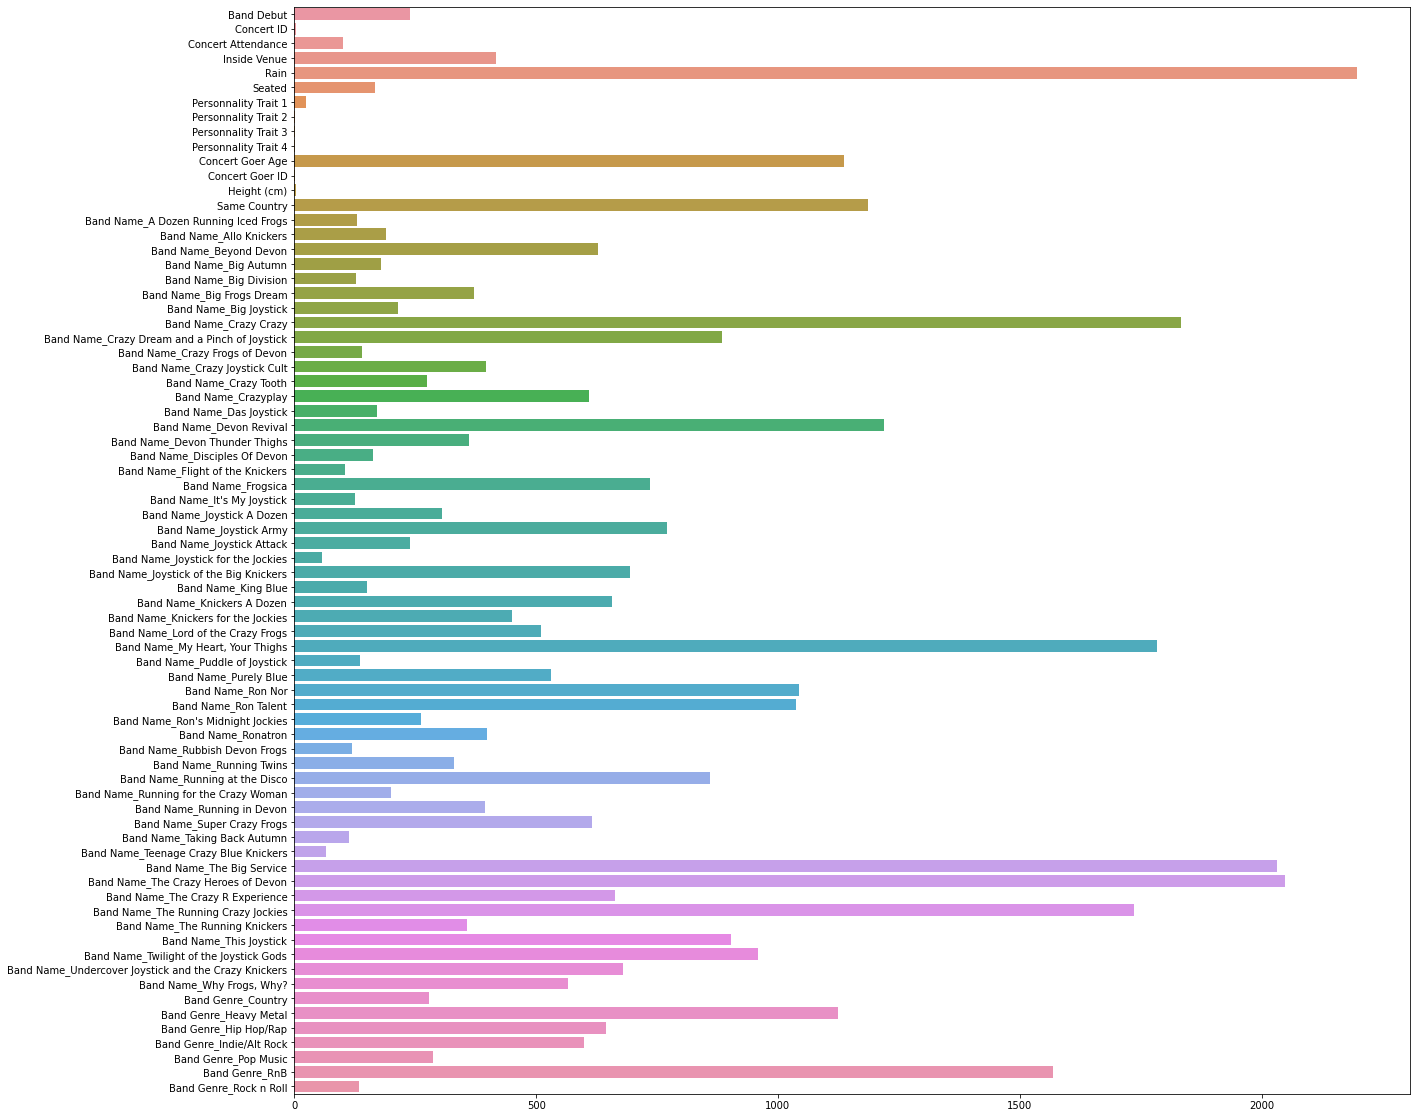

In [ ]:
# there's not much correlation between features
# we can reduce the number of features with sklearn
from sklearn.feature_selection import SelectKBest
import matplotlib.pyplot as plt
import seaborn as sns
skb = SelectKBest()
# we can now fit the SelectKBest to the data
skb.fit(features, labels)
# we can now plot the sorted features by their importance
# we can use the barplot function to plot the sorted features by their importance
# we can use the subplots function to plot the data

plt.figure(figsize=(20, 20))
sns.barplot(x=skb.scores_, y=features.columns)
plt.show()

In [ ]:
# we used the default f_classic which is used for classification problems. The way that function works, is that it calculates the ANOVA F-value for the features and returns the k best features based on that value. The higher the value the more important the feature is.
# we can see in the above plot that there are 6 features that have really low importance compared to the others so we can try keeping 10
#from sklearn.feature_selection import SelectKBest


selected_features = SelectKBest(k=74).fit_transform(features, labels) 

Multiple tests were done using different k values but the performances of the models did not improve, therefore we overwrote the selected_features variable in the next section restoring the original features.

## 1.5- Split dataset

In [ ]:
selected_features = features.values
print(selected_features.shape)

(168484, 74)


In [ ]:
#check shapes:
print('features type:', type(selected_features), 'of shape:', selected_features.shape, '| NaN values:', np.isnan(selected_features.any()), "| finite values:", np.isfinite(selected_features.all()), "| data type:", selected_features.dtype)
print('labels type:', type(labels), 'of shape:', labels.shape, ' NaN values:', np.isnan(labels.any()), "| finite values:", np.isfinite(labels.all()), "|data type:", labels.dtype)

features type: <class 'numpy.ndarray'> of shape: (168484, 74) | NaN values: False | finite values: True | data type: float64
labels type: <class 'numpy.ndarray'> of shape: (168484,)  NaN values: False | finite values: True |data type: int64


In [ ]:
# train test split 
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(selected_features, labels, test_size=0.2, random_state=42)
#We will use the test dataset as a validation dataset, since we already have a test set for the final evaluation 

In [ ]:
print('Train features shape:', X_train.shape, 'Train labels shape:', y_train.shape)
print('Val features shape:', X_val.shape, 'Val labels shape:', y_val.shape)

Train features shape: (134787, 74) Train labels shape: (134787,)
Val features shape: (33697, 74) Val labels shape: (33697,)


In [ ]:
print('X_train type:', type(X_train), 'of shape:', X_train.shape, '| NaN values:', np.isnan(X_train.any()), "| finite values:", np.isfinite(X_train.all()), "| data type:", X_train.dtype)
print('X_val type  :', type(X_val), 'of shape:', X_val.shape, '| NaN values:', np.isnan(X_val.any()), "| finite values:", np.isfinite(X_val.all()), "| data type:", X_val.dtype)
print('y_train type:', type(y_train), 'of shape:', y_train.shape, ' NaN values:', np.isnan(y_train.any()), "| finite values:", np.isfinite(y_train.all()), "|data type:", y_train.dtype)
print('y_val type  :', type(y_val), 'of shape:', y_val.shape, ' NaN values:', np.isnan(y_val.any()), "| finite values:", np.isfinite(y_val.all()), "|data type:", y_val.dtype)

X_train type: <class 'numpy.ndarray'> of shape: (134787, 74) | NaN values: False | finite values: True | data type: float64
X_val type  : <class 'numpy.ndarray'> of shape: (33697, 74) | NaN values: False | finite values: True | data type: float64
y_train type: <class 'numpy.ndarray'> of shape: (134787,)  NaN values: False | finite values: True |data type: int64
y_val type  : <class 'numpy.ndarray'> of shape: (33697,)  NaN values: False | finite values: True |data type: int64


# 2- Training models

Helper functions:

In [ ]:
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

def fit_and_predict(model, x_fit: np.ndarray, y_fit: np.ndarray, x_pred: np.ndarray, y_true: np.ndarray) -> float:
    """ Fits a sklearn model using x_fit and y_fit and predicts the labels for x_pred. Returns the F1 score between the model predictions and y_pred

    Args:
        model: sklearn model
        x_fit (np.ndarray): the samples to fit
        y_fit (np.ndarray): the labels to fit
        x_pred (np.ndarray): the samples to predict
        y_true (np.ndarray): the ground truth labels

    Returns:
        f1_score (float): F1 score between the model predictions for x_pred and the ground truth (y_pred)
    """
    # This funtion was taken from assignment 3
    model.fit(x_fit, y_fit )
    y_pred_model = model.predict(x_pred)
    f1 = f1_score(y_true, y_pred_model, average='micro') 
    acc = accuracy_score(y_true, y_pred_model)
    cm = confusion_matrix(y_true, y_pred_model)
    print('Training f1 score is:', f1)
    print('Training Accuracy:',acc*100,"%")  
    print('Training Confusion Matrix is')
    print(cm)


    return f1, acc, cm


from sklearn.model_selection import RandomizedSearchCV
def hyper_parameter_tuning(model, distribution:dict, selected_features:np.array, labels:np.array):
    """ Searches for the best hyperparameter combinations

      Args:
          model: sklearn model
          distribution (dict): the hyperparameter values to try
          selected_features (np.ndarray): the samples to predict
          labels (np.ndarray): the ground truth labels

      Returns:
          rs.best_params_ : The best value for every hyper-parameter in the dictionnary
          rs.best_score_  : the corresponding score
      """

    rs = RandomizedSearchCV(model, distributions, cv=3)
    rs.fit(selected_features, labels)
    print('Best parameters: ', rs.best_params_)
    print('Best score: ', rs.best_score_)
    return rs.best_params_, rs.best_score_

*Note: since the hyper-parameter tuning uses the RandomizedSerachCV dunction, it is possible that re-reunning the notebook produces different results than what was in the report *

## Linear Discriminant Analysis

**Baseline**

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

model = LinearDiscriminantAnalysis()

# train the model
f1_train, acc_train, cm_train = fit_and_predict(model, X_train, y_train, X_train, y_train)

# compute the eval metrics on the test
val_pred = model.predict(X_val)

f1_val = f1_score(y_val, val_pred, average='micro')
acc = accuracy_score(y_val, val_pred)
cm = confusion_matrix(y_val, val_pred)

print("___________________________________________________")

print('Validation f1 score is:', f1_val)
print('Validation Accuracy:',acc*100,"%")  
print('Validation Confusion Matrix is')
print(cm)

Training f1 score is: 0.5965931432556553
Training Accuracy: 59.659314325565525 %
Training Confusion Matrix is
[[ 5915  7264   304     2]
 [ 5735 34277 13492   359]
 [  369 12727 36025  4794]
 [    3   431  8894  4196]]
___________________________________________________
Validation f1 score is: 0.5963438881799566
Validation Accuracy: 59.634388817995664 %
Validation Confusion Matrix is
[[1521 1796   77    0]
 [1444 8612 3353   97]
 [ 101 3196 8923 1253]
 [   0   93 2192 1039]]


**Hyper-parameter tuning**

In [ ]:
model = LinearDiscriminantAnalysis()

distributions = dict()
distributions['solver'] = ['svd', 'lsqr', 'eigen']
distributions['shrinkage'] = np.arange(0, 1, 0.01)

cbc_best_params, cbc_best_score = hyper_parameter_tuning(LinearDiscriminantAnalysis(), distribution = distributions, selected_features=selected_features, labels=labels)


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
3 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/discriminant_analysis.py", line 583, in fit
    raise NotImplementedError("shrinkage not supported")
NotImplementedError: shrinkage not supported

  warnings.warn(some_fits_failed_message, FitFailedWarning)
/usr/local/lib/python3.8/dist-packages/sklearn/model_selec

Best parameters:  {'solver': 'lsqr', 'shrinkage': 0.05}
Best score:  0.6062356010664213


Results:

Best parameters:  'solver': 'lsqr', 'shrinkage': 0.05

Best score:  0.6062356010664213

**Retraining with hyper-tuned parameters**

In [ ]:
model = LinearDiscriminantAnalysis(solver = "lsqr", shrinkage = 0.05)

# train the model
f1_train, acc_train, cm_train = fit_and_predict(model, X_train, y_train, X_train, y_train)

# compute the eval metrics on the test
val_pred = model.predict(X_val)
f1_val = f1_score(y_val, val_pred, average='micro')
acc = accuracy_score(y_val, val_pred)
cm = confusion_matrix(y_val, val_pred)

print("___________________________________________________")

print('Validation f1 score is:', f1_val)
print('Validation Accuracy:',acc*100,"%")  
print('Validation Confusion Matrix is')
print(cm)

Training f1 score is: 0.6050583513246827
Training Accuracy: 60.50583513246826 %
Training Confusion Matrix is
[[ 4498  8678   308     1]
 [ 3569 36205 13907   182]
 [  191 12730 37812  3182]
 [    1   439 10045  3039]]
___________________________________________________
Validation f1 score is: 0.6047719381547318
Validation Accuracy: 60.477193815473186 %
Validation Confusion Matrix is
[[1137 2183   74    0]
 [ 881 9123 3459   43]
 [  56 3185 9368  864]
 [   0   94 2479  751]]


## SVM

**Baseline**

In [ ]:
from sklearn.svm import LinearSVC


model = LinearSVC()

# train the model
f1_train, acc_train, cm_train = fit_and_predict(model, X_train, y_train, X_train, y_train)

# compute the eval metrics on the test
val_pred = model.predict(X_val)

f1_val = f1_score(y_val, val_pred, average='micro')
acc = accuracy_score(y_val, val_pred)
cm = confusion_matrix(y_val, val_pred)

print("___________________________________________________")

print('Validation f1 score is:', f1_val)
print('Validation Accuracy:',acc*100,"%")  
print('Validation Confusion Matrix is')
print(cm)


/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Training f1 score is: 0.60261746310846
Training Accuracy: 60.261746310846 %
Training Confusion Matrix is
[[ 1200 11891   393     1]
 [  446 39466 13951     0]
 [   14 13401 40470    30]
 [    0   464 12971    89]]
___________________________________________________
Validation f1 score is: 0.6030210404487046
Validation Accuracy: 60.30210404487046 %
Validation Confusion Matrix is
[[  306  2999    89     0]
 [  123  9869  3514     0]
 [    5  3337 10123     8]
 [    0   104  3198    22]]


**Hyper-parameter tuning**

In [ ]:
from sklearn.svm import LinearSVC

distributions = {'C': [0.1, 1, 10, 100], 
              'multi_class':['ovr', 'crammer_singer'],
              'max_iter' : [100, 1000, 10000]} 


cbc_best_params, cbc_best_score = hyper_parameter_tuning(LinearSVC(), distribution = distributions, selected_features=selected_features, labels=labels)


Results: 
Best parameters:  multi_class= 'ovr', max_iter = 10000, C = 1
Best score:  0.5963889665252339

**Retraining with tuned hyper-parameters**

In [ ]:
model = LinearSVC(multi_class= 'ovr', max_iter = 10000, C = 1)

# train the model
f1_train, acc_train, cm_train = fit_and_predict(model, X_train, y_train, X_train, y_train)

# compute the eval metrics on the test
val_pred = model.predict(X_val)
f1_val = f1_score(y_val, val_pred, average='micro')
acc = accuracy_score(y_val, val_pred)
cm = confusion_matrix(y_val, val_pred)

print("___________________________________________________")

print('Validation f1 score is:', f1_val)
print('Validation Accuracy:',acc*100,"%")  
print('Validation Confusion Matrix is')
print(cm)

Training f1 score is: 0.5980695467663796
Training Accuracy: 59.80695467663796 %
Training Confusion Matrix is
[[ 1134 11911   440     0]
 [  435 39165 14262     1]
 [   15 13617 40262    21]
 [    0   542 12931    51]]
___________________________________________________
Validation f1 score is: 0.5965516218060954
Validation Accuracy: 59.655162180609544 %
Validation Confusion Matrix is
[[  288  3018    88     0]
 [  128  9725  3653     0]
 [    5  3377 10082     9]
 [    0   125  3192     7]]


## Logistic Regression

**Baseline**

In [ ]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()

# train the model
f1_train, acc_train, cm_train = fit_and_predict(model, X_train, y_train, X_train, y_train)

# compute the eval metrics on the test
val_pred = model.predict(X_val)
f1_val = f1_score(y_val, val_pred, average='micro')
acc = accuracy_score(y_val, val_pred)
cm = confusion_matrix(y_val, val_pred)

print("___________________________________________________")

print('Validation f1 score is:', f1_val)
print('Validation Accuracy:',acc*100,"%")  
print('Validation Confusion Matrix is')
print(cm)

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training f1 score is: 0.6187021003509241
Training Accuracy: 61.87021003509241 %
Training Confusion Matrix is
[[ 4006  9215   264     0]
 [ 2255 37789 13768    51]
 [   85 12834 39552  1444]
 [    1   416 11061  2046]]
___________________________________________________
Validation f1 score is: 0.6179185090660889
Validation Accuracy: 61.79185090660889 %
Validation Confusion Matrix is
[[ 979 2345   70    0]
 [ 564 9480 3451   11]
 [  26 3219 9822  406]
 [   0   94 2689  541]]


**Hyper-parameter tuning**

In [ ]:
from sklearn.linear_model import LogisticRegression

distributions = {'C': [0.1, 1, 10, 100, 1000], 
              'multi_class':['auto', 'ovr', 'multinomial'],
              'max_iter' : [100, 1000, 10000],
              'solver' : ['newton-cg', 'sag', 'saga', 'lbfgs']} 


cbc_best_params, cbc_best_score = hyper_parameter_tuning(LogisticRegression(), distribution = distributions, selected_features=selected_features, labels=labels)


Resuts:
Best parameters:  

'solver': 'sag', 'multi_class': 'auto', 'max_iter': 1000, 'C': 0.1
Best score:  0.6081883086011556

**Retraining with tuned parameters**

In [ ]:
model = LogisticRegression(solver ='sag', multi_class = 'auto', max_iter = 1000, C = 0.1)

# train the model
f1_train, acc_train, cm_train = fit_and_predict(model, X_train, y_train, X_train, y_train)

# compute the eval metrics on the test
val_pred = model.predict(X_val)
f1_val = f1_score(y_val, val_pred, average='micro')
acc = accuracy_score(y_val, val_pred)
cm = confusion_matrix(y_val, val_pred)

print("___________________________________________________")

print('Validation f1 score is:', f1_val)
print('Validation Accuracy:',acc*100,"%")  
print('Validation Confusion Matrix is')
print(cm)

Training f1 score is: 0.6098362601734588
Training Accuracy: 60.983626017345884 %
Training Confusion Matrix is
[[ 3373  9777   335     0]
 [ 1826 37660 14359    18]
 [   79 13129 39961   746]
 [    1   530 11789  1204]]
___________________________________________________
Validation f1 score is: 0.608689200819064
Validation Accuracy: 60.868920081906396 %
Validation Confusion Matrix is
[[ 817 2497   80    0]
 [ 457 9414 3632    3]
 [  16 3286 9962  209]
 [   0  129 2877  318]]


## Random Forest

**Baseline**

In [ ]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier()

# train the model
f1_train, acc_train, cm_train = fit_and_predict(model, X_train, y_train, X_train, y_train)

# compute the eval metrics on the test
val_pred = model.predict(X_val)
f1_val = f1_score(y_val, val_pred, average='micro')
acc = accuracy_score(y_val, val_pred)
cm = confusion_matrix(y_val, val_pred)

print("___________________________________________________")

print('Validation f1 score is:', f1_val)
print('Validation Accuracy:',acc*100,"%")  
print('Validation Confusion Matrix is')
print(cm)

Training f1 score is: 0.9942872828982023
Training Accuracy: 99.42872828982023 %
Training Confusion Matrix is
[[13362   120     3     0]
 [   67 53598   195     3]
 [    3   172 53678    62]
 [    0     1   144 13379]]
___________________________________________________
Validation f1 score is: 0.6498798112591625
Validation Accuracy: 64.98798112591625 %
Validation Confusion Matrix is
[[1356 2017   21    0]
 [ 673 9705 3111   17]
 [  16 2960 9845  652]
 [   0   42 2289  993]]


**Hyper-parameter tuning**

In [ ]:
from sklearn.ensemble import RandomForestClassifier

n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
max_features = ['log2', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False] 

distributions = {'n_estimators': n_estimators,
                 'max_features': max_features,
                 'max_depth': max_depth,
                 'min_samples_split': min_samples_split,
                 'min_samples_leaf': min_samples_leaf,
                 'bootstrap': bootstrap}

cbc_best_params, cbc_best_score = hyper_parameter_tuning(RandomForestClassifier(), distribution=distributions, selected_features=selected_features, labels=labels)

Best parameters:  {'n_estimators': 500, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 100, 'bootstrap': False}
Best score:  0.6576351595854124


## Decision Tree

**Baseline**

In [ ]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier()

# train the model
f1_train, acc_train, cm_train = fit_and_predict(model, X_train, y_train, X_train, y_train)

# compute the eval metrics on the test
val_pred = model.predict(X_val)
f1_val = f1_score(y_val, val_pred, average='micro')
acc = accuracy_score(y_val, val_pred)
cm = confusion_matrix(y_val, val_pred)

print("___________________________________________________")

print('Validation f1 score is:', f1_val)
print('Validation Accuracy:',acc*100,"%")  
print('Validation Confusion Matrix is')
print(cm)

Training f1 score is: 0.9942872828982023
Training Accuracy: 99.42872828982023 %
Training Confusion Matrix is
[[13485     0     0     0]
 [  187 53672     4     0]
 [    6   363 53543     3]
 [    0     4   203 13317]]
___________________________________________________
Validation f1 score is: 0.5499302608540819
Validation Accuracy: 54.99302608540819 %
Validation Confusion Matrix is
[[1561 1667  164    2]
 [1777 7870 3631  228]
 [ 188 3610 7741 1934]
 [   3  244 1718 1359]]


**Hyper-parameter tuning**

In [ ]:
from sklearn.tree import DecisionTreeClassifier


max_depth = [5, 10, 15, 25, 30]
min_samples_split = [2, 5, 10, 15, 100]
min_samples_leaf = [1, 2, 5, 10]
max_features = [1, 2, 5, 10]


distributions = dict(max_depth = max_depth, 
              min_samples_split = min_samples_split, 
              min_samples_leaf = min_samples_leaf, 
              max_features=max_features)

cbc_best_params, cbc_best_score = hyper_parameter_tuning(DecisionTreeClassifier(), distribution=distributions, selected_features=selected_features, labels=labels)

Best parameters:  {'min_samples_split': 100, 'min_samples_leaf': 10, 'max_features': 10, 'max_depth': 25}
Best score:  0.607618524940849


**After finetuning.**

In [ ]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier(max_depth = 25, min_samples_split = 100, min_samples_leaf = 100, max_features =10)

# train the model
f1_train, acc_train, cm_train = fit_and_predict(model, X_train, y_train, X_train, y_train)

# compute the eval metrics on the test
val_pred = model.predict(X_val)
f1_val = f1_score(y_val, val_pred, average='micro')
acc = accuracy_score(y_val, val_pred)
cm = confusion_matrix(y_val, val_pred)

print("___________________________________________________")

print('Validation f1 score is:', f1_val)
print('Validation Accuracy:',acc*100,"%")  
print('Validation Confusion Matrix is')
print(cm)

Training f1 score is: 0.6167360353743313
Training Accuracy: 61.67360353743313 %
Training Confusion Matrix is
[[ 3923  9065   497     0]
 [ 2237 37630 13935    61]
 [  157 12809 39609  1340]
 [    4   722 10832  1966]]
___________________________________________________
Validation f1 score is: 0.6111523281004244
Validation Accuracy: 61.11523281004244 %
Validation Confusion Matrix is
[[ 949 2323  122    0]
 [ 556 9346 3586   18]
 [  50 3239 9819  365]
 [   0  165 2679  480]]


## XGBClassifier

**Baseline:**

In [ ]:
from xgboost import XGBClassifier

model = XGBClassifier()

# train the model
f1_train, acc_train, cm_train = fit_and_predict(model, X_train, y_train, X_train, y_train)

# compute the eval metrics on the test
val_pred = model.predict(X_val)
f1_val = f1_score(y_val, val_pred, average='micro')
acc = accuracy_score(y_val, val_pred)
cm = confusion_matrix(y_val, val_pred)

print("___________________________________________________")

print('Validation f1 score is:', f1_val)
print('Validation Accuracy:',acc*100,"%")  
print('Validation Confusion Matrix is')
print(cm)

Training f1 score is: 0.62357645767025
Training Accuracy: 62.357645767025005 %
Training Confusion Matrix is
[[ 2722 10549   214     0]
 [  988 39480 13391     4]
 [   15 12315 41455   130]
 [    0   303 12828   393]]
___________________________________________________
Validation f1 score is: 0.6213015995489213
Validation Accuracy: 62.13015995489213 %
Validation Confusion Matrix is
[[  673  2671    50     0]
 [  229  9833  3444     0]
 [    2  3103 10328    40]
 [    0    57  3165   102]]


**Hyper-parameter tuning**

In [ ]:
# TODO
distributions = dict(
    iterations=np.arange(100, 2000, 100),
    learning_rate=[0.1 , 0.01 , 0.001],
    max_depth=[3 , 5 , 7],
    colsample_bytree = np.arange(0.2 , 1 , 0.4),
    subsample = np.arange(0.7 , 1 , 0.1),
    gamma = [ 0 , 1 , 5], 
    n_estimators = np.arange( 50 , 150 , 25)
)

cbc_best_params, cbc_best_score = hyper_parameter_tuning(XGBClassifier(), distribution = distributions, selected_features=selected_features, labels=labels)


Best parameters:  {'subsample': 0.8999999999999999, 'n_estimators': 75, 'max_depth': 3, 'learning_rate': 0.1, 'iterations': 900, 'gamma': 1, 'colsample_bytree': 0.2}
Best score:  0.5977481998593945


**After finetuning.**

In [ ]:
from xgboost import XGBClassifier

model = XGBClassifier(iterations=1400,
    learning_rate=0.1,
    max_depth=7,
    colsample_bytree =0.6,
    subsample =0.7,
    gamma = 5, 
    n_estimators = 100)

# train the model
f1_train, acc_train, cm_train = fit_and_predict(model, X_train, y_train, X_train, y_train)

# compute the eval metrics on the test
val_pred = model.predict(X_val)
f1_val = f1_score(y_val, val_pred, average='micro')
acc = accuracy_score(y_val, val_pred)
cm = confusion_matrix(y_val, val_pred)

print("___________________________________________________")

print('Validation f1 score is:', f1_val)
print('Validation Accuracy:',acc*100,"%")  
print('Validation Confusion Matrix is')
print(cm)

Training f1 score is: 0.6516132861477739
Training Accuracy: 65.16132861477739 %
Training Confusion Matrix is
[[ 4563  8813   109     0]
 [ 1692 40137 12024    10]
 [   27 12046 41043   799]
 [    0   257 11181  2086]]
___________________________________________________
Validation f1 score is: 0.646318663382497
Validation Accuracy: 64.6318663382497 %
Validation Confusion Matrix is
[[ 1120  2244    30     0]
 [  418  9988  3097     3]
 [    7  3046 10173   247]
 [    0    47  2779   498]]


In [ ]:
xgb = XGBClassifier(iterations=1400,
    learning_rate=0.1,
    max_depth=7,
    colsample_bytree =0.6,
    subsample =0.7,
    gamma = 5, 
    n_estimators = 100)
xgb.fit(selected_features, labels)
y_pred_cbc = xgb.predict(test_features)[:, 0]
print('F1 Score: ', f1_score(labels, xgb.predict(selected_features), average='micro'))

In [ ]:
print('F1 Score: ', f1_score(labels, xgb.predict(selected_features), average='micro'))

F1 Score:  0.6536110253792645


## CatBoost

**Baseline**

In [ ]:
from catboost import CatBoostClassifier

model = CatBoostClassifier(verbose=False)

# train the model
f1_train, acc_train, cm_train = fit_and_predict(model, X_train, y_train, X_train, y_train)

# compute the eval metrics on the test
val_pred = model.predict(X_val)
f1_val = f1_score(y_val, val_pred, average='micro')
acc = accuracy_score(y_val, val_pred)
cm = confusion_matrix(y_val, val_pred)

print("___________________________________________________")

print('Validation f1 score is:', f1_val)
print('Validation Accuracy:',acc*100,"%")  
print('Validation Confusion Matrix is')
print(cm)

Training f1 score is: 0.7015216601007516
Training Accuracy: 70.15216601007516 %
Training Confusion Matrix is
[[ 6176  7247    62     0]
 [ 1906 41430 10509    18]
 [   28 10160 42163  1564]
 [    1   130  8606  4787]]
___________________________________________________
Validation f1 score is: 0.6728492150636555
Validation Accuracy: 67.28492150636555 %
Validation Confusion Matrix is
[[ 1417  1963    14     0]
 [  559 10032  2906     9]
 [    9  2756 10191   517]
 [    0    26  2265  1033]]


**Hyper-parameter tuning**

In [ ]:
from catboost import CatBoostClassifier

distributions = dict(
    iterations=np.arange(100, 2000, 100),
    learning_rate=np.arange(0.05, 0.15, 0.01),
    depth=np.arange(8, 15, 1),
    l2_leaf_reg=np.arange(1, 10, 1),
    border_count=np.arange(1, 255, 1),
)

cbc_best_params, cbc_best_score = hyper_parameter_tuning(CatBoostClassifier(verbose=False), distribution = distributions, selected_features=selected_features, labels=labels)


Best parameters:  {'learning_rate': 0.05, 'l2_leaf_reg': 9, 'iterations': 1400, 'depth': 9, 'border_count': 251}
Best score:  0.6687816048584722


result: 
learning_rate: 0.1, 
l2_leaf_reg: 1
iterations: 1500, 
depth: 8, 
border_count: 137

**Retraining with tuned hyper-parameters**

In [ ]:
model = CatBoostClassifier(learning_rate = 0.1, l2_leaf_reg = 1, iterations = 1500, depth = 8, border_count = 137, verbose=False)

# train the model
f1_train, acc_train, cm_train = fit_and_predict(model, X_train, y_train, X_train, y_train)

# compute the eval metrics on the test
val_pred = model.predict(X_val)
f1_val = f1_score(y_val, val_pred, average='micro')
acc = accuracy_score(y_val, val_pred)
cm = confusion_matrix(y_val, val_pred)

print("___________________________________________________")

print('Validation f1 score is:', f1_val)
print('Validation Accuracy:',acc*100,"%")  
print('Validation Confusion Matrix is')
print(cm)

**Train on the entire dataset (train and val) with the hypertuned parameters         THIS IS THE SELECTED MODEL**

In [ ]:
from catboost import CatBoostClassifier
cbc = CatBoostClassifier(learning_rate = 0.1, l2_leaf_reg = 1, iterations = 1500, depth = 8, border_count = 137, verbose=False)
cbc.fit(selected_features, labels)
y_pred_cbc = cbc.predict(test_features)[:, 0]
print('F1 Score: ', f1_score(labels, cbc.predict(selected_features), average='micro'))

learning_rate': 0.05, 'l2_leaf_reg': 3, 'iterations': 300, 'depth': 8, 'border_count': 48}
Best score:  0.647663575364838

## MLP

In [ ]:
from sklearn.neural_network import MLPClassifier

In [ ]:
model = MLPClassifier()

# train the model
f1_train, acc_train, cm_train = fit_and_predict(model, X_train, y_train, X_train, y_train)

# compute the eval metrics on the test
val_pred = model.predict(X_val)
f1_val = f1_score(y_val, val_pred, average='micro')
acc = accuracy_score(y_val, val_pred)
cm = confusion_matrix(y_val, val_pred)

print("___________________________________________________")

print('Validation f1 score is:', f1_val)
print('Validation Accuracy:',acc*100,"%")  
print('Validation Confusion Matrix is')
print(cm)

/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Training f1 score is: 0.683886428216371
Training Accuracy: 68.3886428216371 %
Training Confusion Matrix is
[[ 6643  6772    70     0]
 [ 2843 40109 10832    79]
 [   47 10902 39619  3347]
 [    1   121  7594  5808]]
___________________________________________________
Validation f1 score is: 0.6627889723120752
Validation Accuracy: 66.27889723120752 %
Validation Confusion Matrix is
[[1563 1813   18    0]
 [ 748 9851 2879   28]
 [   6 2887 9581  999]
 [   0   38 1947 1339]]


In [ ]:
distributions = dict(
    hidden_layer_sizes=[(2 ** i,) for i in range(1, 10)],
    activation=["identity", "logistic", "tanh", "relu"],
    solver=["lbfgs", "sgd", "adam"],
    alpha=np.arange(0.0001, 0.1, 0.0001),
    learning_rate=["constant", "invscaling", "adaptive"],
    learning_rate_init=np.arange(0.0001, 0.1, 0.0001),
)


mlp_best_params, mlp_best_score = hyper_parameter_tuning(MLPClassifier(), distribution = distributions, selected_features=selected_features, labels=labels)

print(mlp_best_params)
print(mlp_best_score)


/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

Best parameters:  {'solver': 'lbfgs', 'learning_rate_init': 0.0174, 'learning_rate': 'constant', 'hidden_layer_sizes': (128,), 'alpha': 0.05530000000000001, 'activation': 'tanh'}
Best score:  0.6557655434227252
{'solver': 'lbfgs', 'learning_rate_init': 0.0174, 'learning_rate': 'constant', 'hidden_layer_sizes': (128,), 'alpha': 0.05530000000000001, 'activation': 'tanh'}
0.6557655434227252


/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


In [ ]:
model = MLPClassifier(hidden_layer_sizes=(16, 4), alpha=0.42500000000000004, learning_rate_init=0.15, learning_rate='invscaling', activation='logistic', solver='lbfgs')

# train the model
f1_train, acc_train, cm_train = fit_and_predict(model, X_train, y_train, X_train, y_train)

# compute the eval metrics on the test
val_pred = model.predict(X_val)

f1_val = f1_score(y_val, val_pred, average='micro')
acc = accuracy_score(y_val, val_pred)
cm = confusion_matrix(y_val, val_pred)

print("___________________________________________________")

print('Validation f1 score is:', f1_val)
print('Validation Accuracy:',acc*100,"%")  
print('Validation Confusion Matrix is')
print(cm)

Training f1 score is: 0.6532380719208826
Training Accuracy: 65.32380719208825 %
Training Confusion Matrix is
[[ 5647  7727   111     0]
 [ 2840 38761 12213    49]
 [   46 11603 39895  2371]
 [    0   194  9585  3745]]
___________________________________________________
Validation f1 score is: 0.6539157788527169
Validation Accuracy: 65.39157788527169 %
Validation Confusion Matrix is
[[1423 1942   29    0]
 [ 699 9681 3116   10]
 [  14 2870 9978  611]
 [   0   42 2329  953]]


/home/bndo/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


In [ ]:
model = MLPClassifier(hidden_layer_sizes=(16, 4), alpha=0.42500000000000004, learning_rate_init=0.15, learning_rate='invscaling', activation='logistic', solver='lbfgs')
model.fit(selected_features, labels)
y_pred_mlp = model.predict(test_features)
print('F1 Score: ', f1_score(labels, model.predict(selected_features), average='micro'))

/home/bndo/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/bndo/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(


F1 Score:  0.654376676717077


# 3- Test The selected model

## Predict

In [ ]:

y_pred = y_pred_cbc

In [ ]:
transdict = {0: 'Worst Concert Ever',
             1: 'Did Not Enjoy',
             2: 'Enjoyed',
             3: 'Best Concert Ever'}

y_pred_labels = [transdict[lbl] for lbl in y_pred]
y_pred_labels[:10]

['Best Concert Ever',
 'Enjoyed',
 'Enjoyed',
 'Enjoyed',
 'Did Not Enjoy',
 'Enjoyed',
 'Enjoyed',
 'Enjoyed',
 'Did Not Enjoy',
 'Enjoyed']

In [ ]:
sample_submission["Predicted"] = y_pred_labels

In [ ]:
sample_submission

,Id,Predicted
0,ConcertExperience_70055,Best Concert Ever
1,ConcertExperience_34799,Enjoyed
2,ConcertExperience_100410,Enjoyed
3,ConcertExperience_106446,Enjoyed
4,ConcertExperience_127249,Did Not Enjoy
...,...,...
29995,ConcertExperience_82288,Did Not Enjoy
29996,ConcertExperience_27139,Did Not Enjoy
29997,ConcertExperience_197434,Enjoyed
29998,ConcertExperience_166029,Worst Concert Ever


Export prediction

In [ ]:
sample_submission.to_csv('submission.csv', index=False)